# Setup
Install and import required packages 
Extract data if it has not already been extracted

In [1]:
# Cell 1

# Uncomment the line below if there are some packages missing
#!pip install -r ../requirements.txt
from extract_data import extract_data
# Uncomment the line below if the files required are missing
#extract_data()

In [2]:
# Cell 2
import warnings
warnings.filterwarnings('ignore')

import pandas_plink as pp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import numpy as np
from functools import reduce
from sklearn.metrics import r2_score
import random
import os
import tarfile
import gzip
from extract_data import extract_data
#extract_data()
from tools import *


%load_ext autoreload
%autoreload 2

# Ensuring correct installation and setup of plink2

In [3]:
# Cell 3



# IF RUNNING THIS RESULTS IN THE ERROR MESSAGE:
# /bin/bash: ./plink2: Permission denied
# UNCOMMENT THE LINE OF CODE BELOW THIS AND RERUN THE CELL THEN RECOMMENT

#######################################
#!chmod 700 plink2
#######################################

# OTHERWISE, SHOULD OUTPUT SOMETHING LIKE 
"""
PLINK v2.0.0-a.6 32-bit (20 Oct 2024)              cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink2 <input flag(s)...> [command flag(s)...] [other flag(s)...]
  plink2 --help [flag name(s)...]

Commands include --rm-dup list, --make-bpgen, --export, --freq, --geno-counts,
--sample-counts, --missing, --hardy, --het, --fst, --indep-pairwise,
--r2-phased, --sample-diff, --make-king, --king-cutoff, --pmerge, --pgen-diff,
--write-samples, --write-snplist, --make-grm-list, --pca, --glm, --adjust-file,
--gwas-ssf, --pheno-svd, --clump, --score-list, --variant-score,
--genotyping-rate, --pgen-info, --validate, and --zst-decompress.

"plink2 --help | more" describes all functions.

"""
!./plink2


PLINK v2.0.0-a.6 32-bit (20 Oct 2024)              cog-genomics.org/plink/2.0/
(C) 2005-2024 Shaun Purcell, Christopher Chang   GNU General Public License v3

  plink2 <input flag(s)...> [command flag(s)...] [other flag(s)...]
  plink2 --help [flag name(s)...]

Commands include --rm-dup list, --make-bpgen, --export, --freq, --geno-counts,
--sample-counts, --missing, --hardy, --het, --fst, --indep-pairwise,
--r2-phased, --sample-diff, --make-king, --king-cutoff, --pmerge, --pgen-diff,
--write-samples, --write-snplist, --make-grm-list, --pca, --glm, --adjust-file,
--gwas-ssf, --pheno-svd, --clump, --score-list, --variant-score,
--genotyping-rate, --pgen-info, --validate, and --zst-decompress.

"plink2 --help | more" describes all functions.


# Loading 1000 Genotypes, GWAS, and f_eur_sample.vcf data

In [4]:
# Cell 4
phenotype_data = '../data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz'

# alleles = .bim (snp. came from vcf file (txt file))
# samples = .fam (family id)
# genotypes = .bed (genotypes). Rows and columns defined by alleles and samples
(alleles, samples, genotypes) = pp.read_plink("../data/LDREF/1000G.EUR.*",
                             verbose=False)
genotypes = pd.DataFrame(genotypes.compute())
genotypes.index = alleles['snp']
P = pd.read_csv(phenotype_data, sep='\t', compression='gzip')

height_eqtl_fp = '../data/Height.gwas.txt.gz'
height_eqtl = pd.read_table(height_eqtl_fp)
height_eqtl.columns = map(str.lower, height_eqtl.columns)
height_eqtl['beta'] = height_eqtl['or'].apply(lambda x: np.log(x))

vcf_fp = '../data/f_eur_sample.vcf'
vcf_df = pd.read_csv(vcf_fp, sep="\t", comment='#')
vcf_df['sample1_int'] = vcf_df['sample1'].apply(lambda x: str_to_phenotype(x))

# Pruning and thresholding SNPs in the GWAS summary statistics

In [5]:
all_outs = []
all_dfs = []

for i in range(1, 23):
    temp_out = f'temp_files/clump_chr_{i}'
    clump_cmd = f'./plink2 --bfile ../data/LDREF/1000G.EUR.{i} --clump {height_eqtl_fp} --clump-p1 1e-4 --clump-r2 0.1 --clump-kb 250 --out {temp_out} --silent'
    all_outs.append(temp_out + '.clumps')
    os.system(clump_cmd)
for out in all_outs:
    all_dfs.append(pd.read_csv(out, sep='\t'))

all_clumped_snps = pd.concat(all_dfs)

written to temp_files/clump_chr_1.clumps.missing_id .
written to temp_files/clump_chr_2.clumps.missing_id .
written to temp_files/clump_chr_3.clumps.missing_id .
written to temp_files/clump_chr_4.clumps.missing_id .
written to temp_files/clump_chr_5.clumps.missing_id .
written to temp_files/clump_chr_6.clumps.missing_id .
written to temp_files/clump_chr_7.clumps.missing_id .
written to temp_files/clump_chr_8.clumps.missing_id .
written to temp_files/clump_chr_9.clumps.missing_id .
written to temp_files/clump_chr_10.clumps.missing_id .
written to temp_files/clump_chr_11.clumps.missing_id .
written to temp_files/clump_chr_12.clumps.missing_id .
written to temp_files/clump_chr_13.clumps.missing_id .
written to temp_files/clump_chr_14.clumps.missing_id .
written to temp_files/clump_chr_15.clumps.missing_id .
written to temp_files/clump_chr_16.clumps.missing_id .
written to temp_files/clump_chr_17.clumps.missing_id .
written to temp_files/clump_chr_18.clumps.missing_id .
written to temp_fil

# Merging individual f_eur_sample.vcf with the 1000 Genomes dataset

In [6]:
h_genotypes = genotypes.loc[all_clumped_snps['ID']].merge(vcf_df[['ID', 'sample1_int']].set_index('ID'), left_index=True, right_index=True, how='left').dropna()
h_alleles = alleles[alleles['snp'].isin(h_genotypes.index)]
pruned_height_eqtl = height_eqtl[height_eqtl['snp'].isin(h_genotypes.index)]
h_samples = samples.copy()
h_samples.iloc[-1] = ['t1', 't1', '0', '0', '0', '-9', 'sample1_int']

# Plotting the individual against the PRS distribution for height

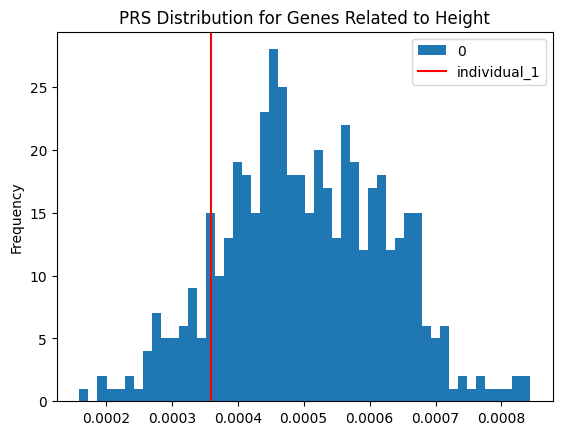

In [7]:
height_prs_vals = prs_gene_pipeline(pruned_height_eqtl, h_samples, h_genotypes, snp_id='snp', p_val=None)
pd.DataFrame.from_dict(height_prs_vals, orient='index').plot(kind='hist', bins=50, label='PRS Distribution')
plt.title('PRS Distribution for Genes Related to Height')
plt.axvline(height_prs_vals['t1'], color='red', label='individual_1')
plt.legend()
plt.show()